# Elon Musk-Like Tweet Generator

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Preparing the language model

First let's load the dataset we will use to create a language model. 

The data is compiled of tweets from Elon Musk.

Twitter data (2010 to 2018):
- 6,094 total tweets
    - 5,249 tweets
    - 845 re-tweets

The Twitter data used to train the data was compiled from 3 Elon Musk Twitter datasets from 2010 to 2018 and duplicates were removed:

1. [2010-06-04 to 2017-04-05](https://data.world/adamhelsinger/elon-musk-tweets-until-4-6-17) from data.world
2. [2017-04-06 to 2017-09-21](https://www.kaggle.com/kulgen/elon-musks-tweets) from kaggle
3. [2017-12-17 tp 2018-12-11](https://data.world/barbaramaseda/elon-musk-tweet) from data.world

In [3]:
df = pd.read_csv('/storage/deep-elon-tweet-generator/musk-tweets-2010-to-2018.csv');
df.head()

,text
0,"Please ignore prior tweets, as that was someon..."
1,Went to Iceland on Sat to ride bumper cars on ...
2,I made the volume on the Model S http://t.co/w...
3,"Great Voltaire quote, arguably better than Twa..."
4,That was a total non sequitur btw


The training data contains 1 tweet per row and has no labels.

In [4]:
# let's look at a single tweet
df['text'][1]

"Went to Iceland on Sat to ride bumper cars on ice!  No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) http://t.co/rBQXJ9IT"

In [5]:
# number of total tweets in training data (2010-2018)
len(df)

6094

In [6]:
# batch size
bs = 48

In [7]:
# create langugage model using our twitter data
data_lm = (TextList.from_df(df,Path('/storage/deep-elon-tweet-generator/'), col=['text']) 
          #We randomly split and keep 10% (~609 tweets) for validation
           .random_split_by_pct(0.1)
          #We want to do a language model so we label accordingly
           .label_for_lm()
          .databunch(bs=bs))
data_lm.save('tmp_lm')

## Tokenization

The first step of processing we make tweets go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few tweets in a batch.

In [8]:
data_lm = TextLMDataBunch.load(Path('/storage/deep-elon-tweet-generator/'), 'tmp_lm', bs=bs)

In [9]:
data_lm.show_batch(rows=10)

idx,text
0,xxbos xxmaj the xxmaj model s beta xxunk car just passed xxunk miles on a single battery pack ! xxbos xxmaj model s xxunk into semi truck xxunk and lifts it off the ground . xxmaj driver xxunk away . https : / / t.co / xxunk xxbos xxup rt @teslamotors : xxmaj xxunk xxmaj xxunk street view from a right hand drive xxmaj model xxup s. http : /
1,https : / / t.co / xxunk xxbos xxunk i want to know who is running the xxmaj xxunk xxunk ! xxmaj mad xxunk ... xxbos xxunk xxmaj thanks xxbos xxup rt @john_gardi : @elonmusk xxmaj you should point out this campaign was n't started by xxup xxunk but by concerned citizens that want a fair deal & & a xxunk \ xe2 \ x80 \ xa6 xxbos @redletterdave xxmaj
2,"xxmaj the cat videos are awesome xxbos xxmaj worth reading xxmaj the xxmaj machine xxmaj stops , an old story by xxup xxunk xxup xxunk xxmaj xxunk https : / / t.co / xxunk xxbos xxmaj expect to reach xxunk xxunk regarding last flight by end of week . xxmaj will brief key customers & & xxup xxunk , then post on our website . xxbos xxup rt @electrekco :"
3,"xxunk xxbos xxup rt @spacex : xxmaj early this morning , @spacex engineers xxunk # xxmaj dragon into the xxmaj port of xxup la http : / / t.co / xxunk xxbos xxunk xxmaj wow , that 's great ! xxbos xxmaj owner video of xxmaj autopilot steering to avoid collision with a truck \n https : / / t.co / xxunk xxbos xxup rt @arstechnica : xxmaj xxunk \"
4,"xxunk xxunk has details https : / / t.co / xxunk ? xxbos xxmaj about to give a talk at the xxmaj xxunk https : / / t.co / xxunk xxbos xxmaj we did n't even have kids back then . xxmaj just little xxunk . xxbos xxmaj xxunk judge xxunk auto dealers ' demand to kill our little xxmaj tesla store . xxmaj yay , justice xxunk ! http"
5,xxunk xxunk xxmaj thanks for offering to help . i will check with my team . xxbos xxup xxunk xxmaj you 're right . xxmaj xxunk is a no - win situation . xxmaj xxunk is going to hate what you say no matter what that is . xxbos lol https : / / t.co / xxunk xxbos xxmaj first flight of 10 story xxunk xxmaj grasshopper rocket using closed
6,"sales xxunk . xxbos xxup rt @spacex : xxmaj falcon 9 and xxmaj telstar 19 xxup vantage went vertical this afternoon on xxmaj pad 40 in xxmaj florida . xxmaj weather is 60 % favorable for the four - hour launch window , which opens xxmaj sunday , xxmaj july 22 at xxunk a.m. xxup edt , xxunk xxup utc . https : / / t.co / gtc39ubc7z https :"
7,"like xxmaj blackrock keep up to 50 % of short interest revenue , but xxunk almost none of xxunk decline , as they 're just "" passive "" managers . xxmaj blackrock made $ xxunk xxbos https : / / t.co / xxunk https : / / t.co / xxunk xxbos @djsnm xxmaj pump is single xxunk . xxmaj some landing systems are not xxunk , as landing is considered"
8,"a boat for short periods of time . xxmaj thrust via wheel xxunk . xxbos xxup rt @teslarati : spacex 's xxmaj mr xxmaj steven xxunk in high - speed test at sea with upgraded net ahead of fairing catch xxunk https : / / t.co / xxunk xxbos xxunk xxmaj early next year . xxmaj to start with , we 're making the xxunk xxmaj model 3 first ,"
9,"what is more xxunk than xxunk xxunk xxunk ? xxmaj xxunk ' the xxunk ... http : / / t.co / xxunk xxbos @samabuelsamid @teslamotors i 've written two forward - looking master plans , but have n't told the xxmaj tesla history of ho ? https : / / t.co / xxunk xxbos xxup rt @spacex : xxmaj close , but no xxunk . xxmaj this time . https"


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

## Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
# view the most common dictionary terms
data_lm.vocab.itos[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/',
 '.',
 ':',
 ',',
 'the',
 'to',
 't.co']

## Train the language model

We're not going to train a model that generates language from scratch. 

Instead, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our tweet generator, but first, we need to fine-tune the pretrained model with Elon's tweets. Because Twitter language/style isn't the same as the English of Wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in Wikipedia, and therefore might no be part of the vocabulary the model was trained on.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [11]:
# drop_mult is a parameter that controls the % of drop-out used
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.30)

In [12]:
# use learning rate finder to identify a good learning rate to use
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


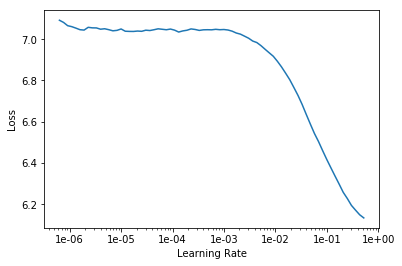

In [13]:
learn.recorder.plot(skip_end=15)

In [14]:
# as a rule of thumb, review the plot above and choose the learning rate with the steepest slope to fit the model
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,6.673347,5.848070,0.201297
2,5.525470,4.180490,0.287321
3,4.683749,3.861969,0.326021
4,4.202083,3.738675,0.335610
5,3.903042,3.669463,0.338576
6,3.682685,3.621780,0.345820
7,3.530087,3.596351,0.348234
8,3.420229,3.582476,0.347647
9,3.348133,3.582009,0.347682
10,3.302161,3.582578,0.347544


In [15]:
learn.save('tweet_head')

In [16]:
learn.load('tweet_head');

To complete the fine-tuning, we can then unfeeze and launch a new training to fine-tune all layers of the model.

In [17]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.271033,3.578148,0.350580
2,3.268870,3.575207,0.350235
3,3.271037,3.573545,0.348027
4,3.255284,3.572066,0.348924
5,3.244405,3.569673,0.348846


In [18]:
learn.save('tweet_fine_tuned')

In [19]:
learn.load('tweet_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (5485 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /storage/deep-elon-tweet-generator
x: LMTextList (5485 items)
[Text xxbos xxmaj please xxunk prior tweets , as that was someone pretending to be me :) xxmaj this is actually me ., Text xxbos xxmaj went to xxmaj xxunk on xxmaj sat to ride bumper cars on ice ! xxmaj no , not the country , xxmaj xxunk 's xxunk in xxmaj van xxmaj xxunk . xxmaj awesome family fun :) http : / / t.co / xxunk, Text xxbos i made the volume on the xxmaj model s http : / / t.co / xxunk m go to 11 . xxmaj now i just need to work in a xxunk xxmaj xxunk ..., Text xxbos xxmaj great xxmaj xxunk quote , arguably better than xxmaj xxunk . xxmaj hearing news of his own death , xxmaj xxunk xxunk the reports were true , only xxunk ., Text xxbos xxmaj that was a total non xxunk btw]...
Path: /storage/deep-elon-tweet-generator;

Valid: LabelList
y: LMLabel (609 items)
[Category

## Tweet Generation Testing

In [20]:
# adjust below parameters to test inference (generated tweets)

TEXT = "Robots will"
N_WORDS = 20
N_SENTENCES = 2

In [21]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

Robots will own a three - character xxup bfr spacecraft companies . this meeting will be that following as no launching xxbos
Robots will act on their later designs . one of the most prominent designs that telstar 1 remains with the credit of
